In [1]:
import torch
import numpy
import sys

sys.path.append('../')
sys.path.append('../model')

In [2]:
from classifiers import EncoderClassifier, EncoderClassifierConfig, SelectiveFinetuningClassifier, SelectiveFinetuningClassifierConfig
from training import run_training, LightningWrapper
from encoder import create_model as create_model_enc, add_arguments as add_arguments_enc
from ft_selective import create_model as create_model_ft
from esm_train import get_esm, device, parser
from data_loading import prepare_datasets
from torchmetrics import F1Score, MatthewsCorrCoef, Precision, Recall, AUROC, \
MeanMetric, AveragePrecision, PrecisionRecallCurve, MetricCollection
from torch.utils.data import DataLoader
from functools import partial
from data_loading import prep_batch

/storage/praha1/home/nexuso1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
chkpt_path = '../model/new_logs/encoder_S_3_res3_650M/fold_0/best.ckpt'
checkpoint = torch.load(chkpt_path)
args = parser.parse_args(args=[])

for k, v in checkpoint['hyper_parameters'].items():
    args.__setattr__(k, v)

model, tokenizer = create_model(args)
# Fix potential dictionary issues with checkpoint keys
prefix = 'classifier.'
for k in list(checkpoint['state_dict'].keys()):
    checkpoint['state_dict'][k.removeprefix(prefix)] = checkpoint['state_dict'].pop(k)
model.load_state_dict(checkpoint['state_dict'])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'Namespace' object has no attribute 'n_layers_mlp'

In [ ]:
model.to(device)

In [4]:
full_dataset = prepare_datasets(args, ignore_label=args.ignore_label)

step_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
})

epoch_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
    'auroc' : AUROC('binary', ignore_index=args.ignore_label),
    'auprc' : AveragePrecision('binary', ignore_index=args.ignore_label),
    'mcc' : MatthewsCorrCoef('binary', ignore_index=args.ignore_label)
})

NameError: name 'args' is not defined

In [ ]:
train_ds, dev_ds, test_ds = full_dataset.get_fold(0)
train = DataLoader(train_ds, args.batch_size, shuffle=True,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False, 
                    num_workers=args.num_workers )
dev = DataLoader(dev_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

test = DataLoader(test_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

In [3]:
class OutputGatherModule(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
        self.last_batch = None
        
    def forward(self, *args, **kwargs):
        out = self.module(*args, **kwargs)
        self.last_batch = out
        return out
    

In [8]:
model.encoder = OutputGatherModule(model.encoder)

In [9]:
embed_df = {}
all_embeds = []
with torch.no_grad():
    for batch in test:
        loss, batch_preds = model.predict(**batch.to(model.device))
        batch_labels = batch['labels']
        embeds = model.encoder.last_batch
        mask = batch_labels != model.ignore_index
        ids = test_ds.data.iloc[batch['indices'].cpu().numpy()]['id']

        # Save the predictions
        for i, id in enumerate(ids):
            embed_df[id] = {}
            embed_df[id]['preds'] = torch.sigmoid(batch_preds[i][mask[i]]).cpu().numpy()
            embed_df[id]['prot_embed'] = embeds[i][0].cpu().numpy()
            embed_df[id]['embeds'] = embeds[i][1:][mask[i]].cpu().numpy()
            all_embeds.extend(embed_df[id]['embeds'].tolist())
            embed_df[id]['mask'] = mask[i].cpu().numpy()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [13]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [14]:
tsne = TSNE(n_jobs=31, random_state=42)

In [12]:
embed_df = pd.DataFrame.from_dict(embed_df, orient='index')

In [13]:
all_embeds = np.asarray(all_embeds)

In [14]:
transformed = tsne.fit_transform(all_embeds)

In [63]:
import matplotlib.pyplot as plt

In [16]:
transformed.shape

(85338, 2)

Text(0.5, 1.0, 'Test set Serine embeddings')

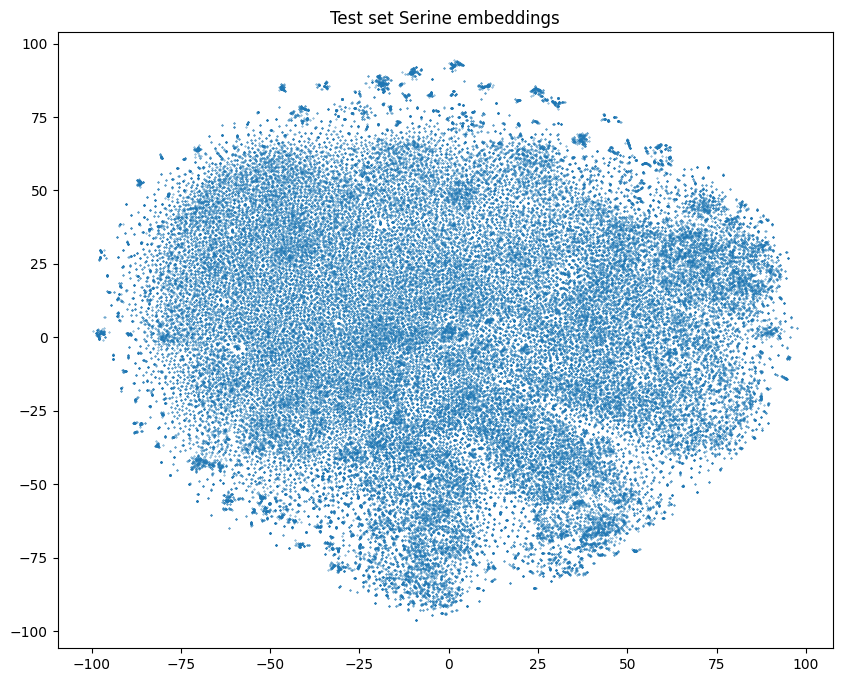

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(transformed[:, 0], transformed[:, 1], s=0.1)
plt.title('Test set Serine embeddings')

In [18]:
labels = []
families = []

In [19]:
kinase_info = pd.read_json('../data/prots_with_kinase_preds.json')

In [20]:
kinase_info.head(5)

id                                              sites  \
0  A0A024R4G9                                       [14, 16, 20]   
1  A0A075B759                                  [40, 79, 93, 119]   
2  A0A087WP46  [359, 972, 973, 974, 988, 997, 1000, 1005, 101...   
3  A0A087WPF7  [32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...   
4  A0A087WQ53                                               [58]   

                                            sequence  \
0  MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...   
1  MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...   
2  MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...   
3  MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...   
4  MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...   

                                        kinase_preds  
0  {'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [...  
1  {'Name': ['MAPKAPK5', 'FGR', 'BIKE', 'ALPHAK3'...  
2  {'Name': ['PRP4', 'YANK3', 'FAK', 'PRPK', 'BUB...  
3  {'Name': ['LKB1', 'HASPIN', 'GSK3B', 'NEK11', ...  
4  {'Name': ['PDGFRA'], 'Family': ['PDGFR'], 'Sco...

In [25]:
kinase_info = kinase_info.set_index('id')

In [22]:
embed_df['sites'] = kinase_info['sites'].apply(lambda x: [int(i) for i in x]) # sites are strings, sites off by 1 by design
embed_df['kinase_preds'] = kinase_info['kinase_preds']

In [23]:
embed_df.head(5)

preds  \
A0A024R4G9  [[0.13994065], [0.22769088], [0.18009713], [0....   
A0A087WQP5            [[0.7504555], [0.6554665], [0.7624211]]   
A0A0R4J0D1  [[0.6511231], [0.5497308], [0.5851145], [0.792...   
A0PJX2      [[0.97019124], [0.9765015], [0.16871011], [0.2...   
A1IGU4      [[0.3703464], [0.31424013], [0.5280014], [0.97...   

                                                   prot_embed  \
A0A024R4G9  [0.40966257, 0.71738523, -0.6757343, -0.335822...   
A0A087WQP5  [0.18872339, 1.0847677, 0.51984954, -0.1639113...   
A0A0R4J0D1  [-0.33538118, 0.82514817, -0.1630842, -0.12008...   
A0PJX2      [0.028619526, 1.1689217, 0.6056464, -0.5343935...   
A1IGU4      [-0.22547376, 1.51678, 0.08070905, 0.11200123,...   

                                                       embeds  \
A0A024R4G9  [[1.3602738, 0.6515395, -1.1895553, 0.8501734,...   
A0A087WQP5  [[0.78615314, 1.0196753, -0.33613542, -0.12197...   
A0A0R4J0D1  [[0.3268655, 1.3882271, 0.06570643, 0.76940143...   
A0PJX2      [[0.89288974, 0.643694, 0.24489944, 0.15504266...   
A1IGU4      [[0.21106136, -0.076378495, -0.72172177, 0.773...   

                                                         mask  \
A0A024R4G9  [False, False, False, False, False, False, Fal...   
A0A087WQP5  [False, False, False, False, False, False, Fal...   
A0A0R4J0D1  [False, False, False, False, True, False, Fals...   
A0PJX2      [False, False, False, False, False, False, Fal...   
A1IGU4      [False, False, False, False, False, False, Fal...   

                         sites  \
A0A024R4G9        [14, 16, 20]   
A0A087WQP5      [98, 102, 107]   
A0A0R4J0D1  [25, 28, 351, 355]   
A0PJX2              [153, 155]   
A1IGU4                   [201]   

                                                 kinase_preds  
A0A024R4G9  {'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [...  
A0A087WQP5  {'Name': ['GSK3B', 'CK1A2', 'TAO3'], 'Family':...  
A0A0R4J0D1  {'Name': ['GSK3B', 'CK1A', 'GSK3B', 'CK1A2'], ...  
A0PJX2      {'Name': ['PDHK4', 'MEKK3'], 'Family': ['PDHK'...  
A1IGU4      {'Name': ['PRKD1'], 'Family': ['CAMK'], 'Score...

In [71]:
labels = []
families = []
preds = []
for id in embed_df.index:
    row = embed_df.loc[id]
    indices = np.nonzero(row['mask'])[0]
    tp_mask = np.asarray([i in row['sites'] for i in indices])
    relevant_sites = indices[tp_mask]
    relevant_site_mask = np.asarray([i in set(relevant_sites) for i in row['sites']])
    # Duplicated sites for some reason
    if tp_mask.sum() != relevant_site_mask.sum():
        print(id)
        print(tp_mask)
        print(indices)
        print(relevant_sites)
        print(row['sites'])
        print(relevant_site_mask)
        print(row['kinase_preds']['Family'])
        r_fams = row['kinase_preds']['Family'] 
        relevant_site_mask[len(r_fams) // 2:] = False
        row['relevant_site_mask'] = relevant_site_mask
        print(relevant_site_mask)
       
    labels.extend(tp_mask)
    families.extend(np.asarray(row['kinase_preds']['Family'])[relevant_site_mask])
    preds.extend(row['preds'])
    

P62806
[False  True]
[ 1 47]
[47]
[47, 51, 72, 80, 88, 47, 51, 72, 80, 88]
[ True False False False False  True False False False False]
['AGC', 'FRK', 'TEC', 'AGC', 'PDGFR', 'AGC', 'FRK', 'TEC', 'AGC', 'PDGFR']
[ True False False False False False False False False False]


In [25]:
tp = transformed[labels]
tn = transformed[np.logical_not(labels)]

Text(0.5, 1.0, 'Test set (fold 0) Serine t-SNE encoder embeddings')

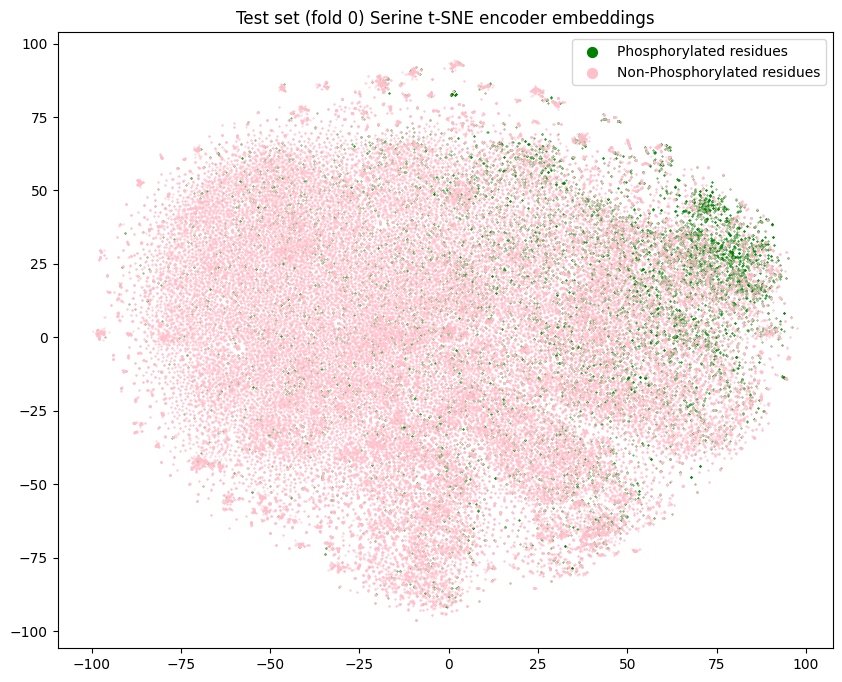

In [136]:
plt.figure(figsize=(10, 8))
plt.scatter(tp[:, 0], tp[:, 1], s=0.5, label='Phosphorylated residues', color='green', marker='.')
plt.scatter(tn[:, 0], tn[:, 1], s=0.5, label='Non-Phosphorylated residues', color='pink', marker='.')
plt.legend(markerscale=20)
plt.title('Test set (fold 0) Serine t-SNE encoder embeddings')

In [27]:
unique_fams = np.unique(families)

In [28]:
fam_to_num = {unique_fams[i] : i for i in range(len(unique_fams))}

In [29]:
fam_labels = np.asarray([fam_to_num[f] for f in families])

In [68]:
from matplotlib import colormaps


In [31]:
cmap = colormaps['gist_rainbow']

In [32]:
np.linspace(0,1,len(unique_fams))

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [59]:
colors = cmap([val * (-1 + 2*(i % 2)) for i, val in enumerate(np.linspace(0,1,len(unique_fams)))])


In [118]:
def create_families_plot(tp, families, name : str):
    unique_fams = np.unique(families)
    fam_to_num = {unique_fams[i] : i for i in range(len(unique_fams))}
    fam_labels = np.asarray([fam_to_num[f] for f in families])
    cmap = colormaps['gist_rainbow']
    colors = cmap(np.linspace(0,1,len(unique_fams)))
    colors[..., -1] = 0.5 # Set alpha
    fig, ax = plt.subplots()
    fig.set_size_inches((9, 6))
    for i,fam in enumerate(fam_to_num.keys()): 
        mask = fam_labels == fam_to_num[fam]
        fam_embeds = tp[mask]
        ax.scatter(fam_embeds[:, 0], fam_embeds[:, 1], label=fam, s=1, color=colors[i])
    ax.legend(markerscale=10, ncols=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f'{name} phoshporylated residue families t-SNE plot')
    fig.tight_layout()
    plt.show()

In [119]:
len(families)

10282

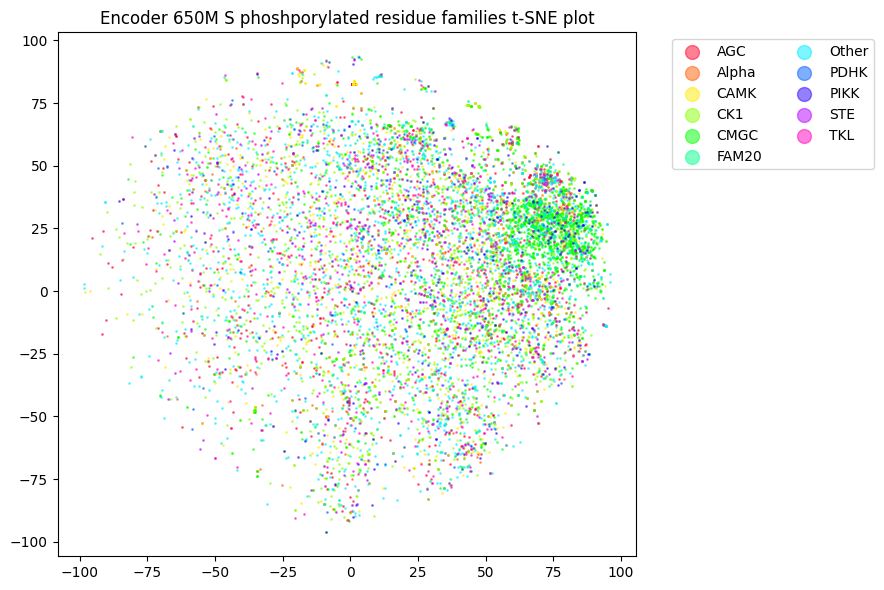

In [120]:
create_families_plot(tp, families, 'Encoder 650M S')

In [29]:
def create_preds_plot(x, y, preds, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (10, 8))
    cmap = colormaps['PiYG']
    
    if isinstance(preds, np.ndarray):
        preds = preds.tolist()
    
    colors = cmap(preds)
    im = ax.scatter(x, y, color=colors, marker='.', s=0.3)
    ax.set_title(title)
    ax.set_xlabel('First component')
    ax.set_ylabel('Second component')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Predicted site probability')
    
    return ax

<Axes: title={'center': 'Encoder 650M S test predictions plot'}>

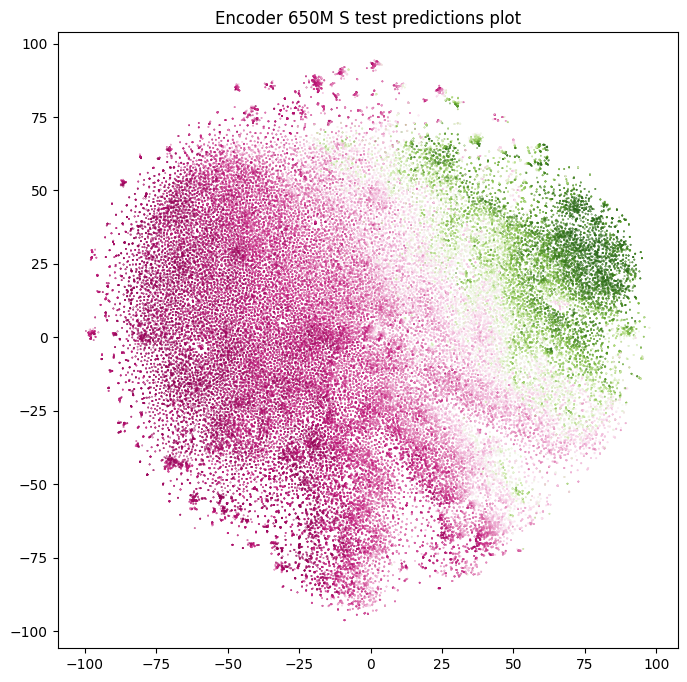

In [135]:
create_preds_plot(transformed[:, 0], transformed[:, 1], np.asarray(preds).flatten(), title='Encoder 650M S test predictions plot')

In [132]:
import seaborn as sns

In [133]:
def density_plot(data, title=None, ax=None):
    df = pd.DataFrame(data)
    if ax is None:
        fig, ax = plt.subplots()
    sns.kdeplot(
    data=df, x=0, y=1,fill=True, thresh=0, levels=50, cmap="mako", ax=ax)
    ax.set_title(title)
    
    return ax

def density_tp_tn(tp, tn, model_name='Encoder Serine 650M'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    density_plot(tp, title=f'{model_name} TP density plot', ax=ax1)
    density_plot(tn, title=f'{model_name} TN density plot', ax=ax2)
    fig.tight_layout()
    return fig, (ax1, ax2)

<Axes: title={'center': 'Encoder Serine 650M'}, xlabel='0', ylabel='1'>

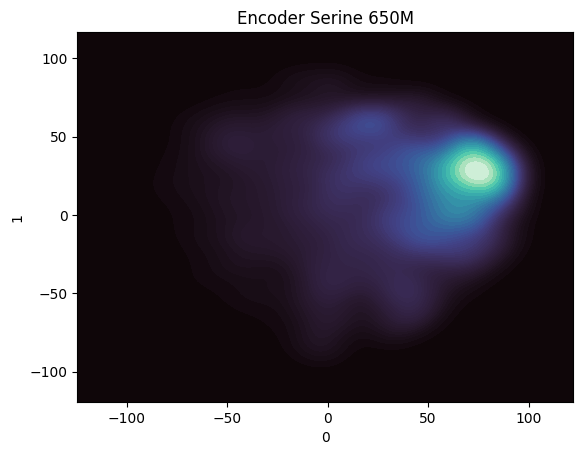

In [39]:
density_plot(tp, 'Encoder Serine 650M')

<Axes: title={'center': 'Encoder Serine 650M TN'}, xlabel='0', ylabel='1'>

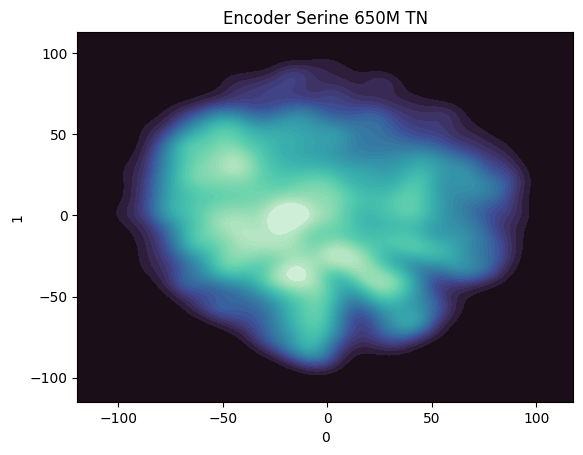

In [40]:
density_plot(tn, 'Encoder Serine 650M TN')

(<Figure size 1200x600 with 2 Axes>,
 (<Axes: title={'center': 'Encoder Serine 650M TP density plot'}, xlabel='0', ylabel='1'>,
  <Axes: title={'center': 'Encoder Serine 650M TN density plot'}, xlabel='0', ylabel='1'>))

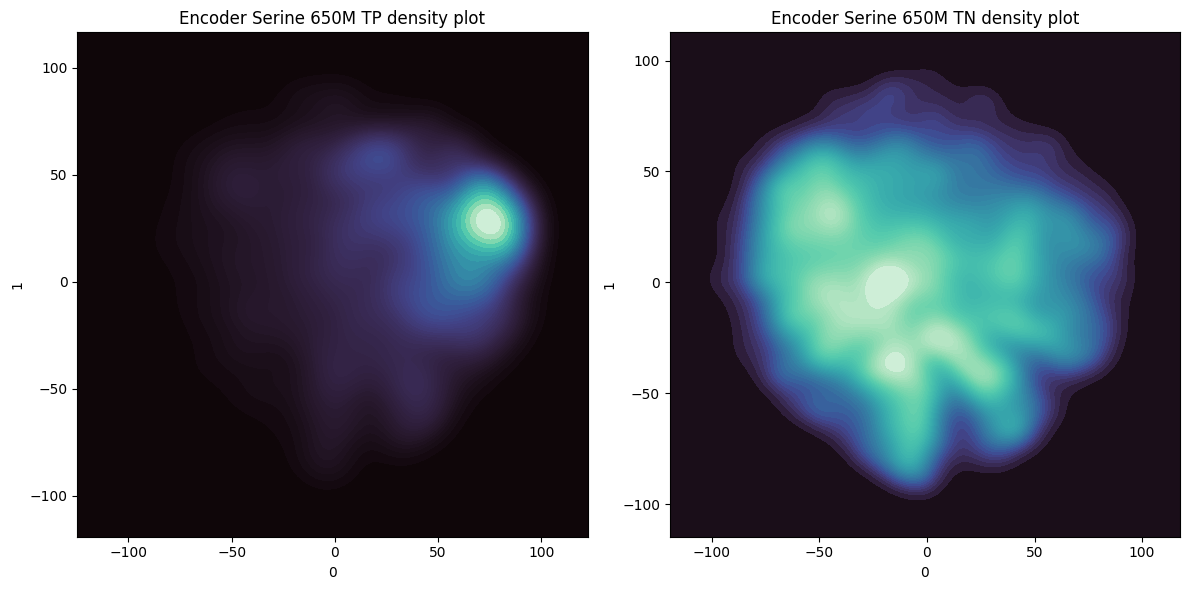

In [134]:
density_tp_tn(tp, tn)

In [139]:
kinase_info['relative_pos_sites'] = kinase_info.apply(lambda row: np.asarray([int(x) / len(row['sequence']) for x in row['sites']]), axis=1)

In [140]:
position_labels = []
for id in embed_df.index:
    row = embed_df.loc[id]
    indices = np.nonzero(row['mask'])[0]
    tp_mask = np.asarray([i in row['sites'] for i in indices])
    relevant_sites = indices[tp_mask]
    relevant_site_mask = np.asarray([i in set(relevant_sites) for i in row['sites']])
    # Duplicated sites for some reason
    
    pos_labels = kinase_info.loc[id]['relative_pos_sites']
    # Duplicated sites
    if tp_mask.sum() != relevant_site_mask.sum():
        relevant_site_mask[len(pos_labels) // 2:] = False
        
    position_labels.extend(pos_labels[relevant_site_mask])
    

In [141]:
len(position_labels)

10282

In [142]:
def create_positional_plot(tp_embeds, pos_labels, model_name):
    fig, ax = plt.subplots()
    cmap = colormaps['plasma']
    colors = cmap(pos_labels)
    print(colors[:5])
    colors[..., -1] = 0.7
    fig.set_size_inches((8, 6))
    ax.scatter(tp_embeds[:, 0], tp_embeds[:, 1], color=colors, marker='.', s=2)
    ax.set_title(f'{model_name} residue sequential position t-SNE plot')
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Residue position / sequence length')
    
    return fig, ax

[[0.318856 0.007576 0.63764  1.      ]
 [0.368733 0.002724 0.650601 1.      ]
 [0.953428 0.52796  0.288883 1.      ]
 [0.968526 0.5697   0.261721 1.      ]
 [0.981826 0.618572 0.231287 1.      ]]


(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Encoder Serine 650M residue sequential position t-SNE plot'}>)

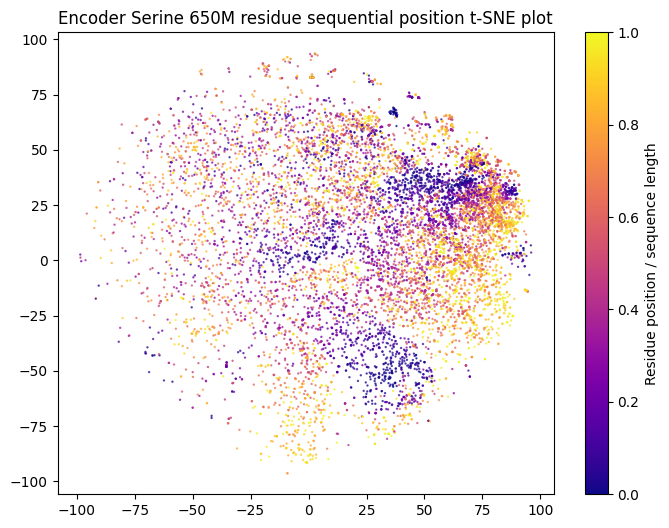

In [143]:
create_positional_plot(tp, position_labels, 'Encoder Serine 650M')

In [23]:
from sklearn.manifold import TSNE
from matplotlib import colormaps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def gather_embeds(model, test, tokenizer, test_ds):
    embed_df = {}
    all_embeds = []
    all_preds = []
    with torch.no_grad():
        for batch in test:
            loss, batch_preds = model.predict(**batch.to(model.device))
            batch_labels = batch['labels']
            embeds = model.encoder.last_batch
            mask = batch_labels != model.ignore_index
            ids = test_ds.data.iloc[batch['indices'].cpu().numpy()]['id']
            
            all_preds.extend(torch.sigmoid(batch_preds[mask]).flatten().cpu().numpy().tolist())

            # Save the predictions
            for i, id in enumerate(ids):
                embed_df[id] = {}
                embed_df[id]['start_index'] = len(all_embeds)
                # First embed is the protein embedding
                all_embeds.extend(embeds[i][1:][mask[i]].cpu().numpy().tolist())
                embed_df[id]['prot_embed'] = embeds[i][0].cpu().numpy()
                embed_df[id]['mask'] = mask[i].cpu().numpy()
                embed_df[id]['logits'] = batch_preds[i][mask[i]].cpu().numpy()
                
    embed_df = pd.DataFrame.from_dict(embed_df, orient='index')
    return embed_df, all_embeds, all_preds
    
def prepare_model(path, create_model_fn, model_type='ft'):
    checkpoint = torch.load(path)
    args = parser.parse_args(args=[])

    for k, v in checkpoint['hyper_parameters'].items():
        args.__setattr__(k, v)

    model, tokenizer = create_model_fn(args)
    # Fix potential dictionary issues with checkpoint keys
    prefix = 'classifier.'
    for k in list(checkpoint['state_dict'].keys()):
        checkpoint['state_dict'][k.removeprefix(prefix)] = checkpoint['state_dict'].pop(k)
    model.load_state_dict(checkpoint['state_dict'])
    
    if model_type == 'ft':
        model.base.encoder.layer[-1] = OutputGatherModule(model.base.encoder.layer[-1])
        
    if model_type == 'enc':
        model.encoder = OutputGatherModule(model.encoder)
        
    else:
        raise ValueError('Unsupported model type')
        
    model.to(device)
    return model, tokenizer, args

def gather_info(embed_df):
    labels = []
    position_labels = []
    families = []
    preds = []
    for id in embed_df.index:
        row = embed_df.loc[id]
        indices = np.nonzero(row['mask'])[0]
        tp_mask = np.asarray([i in row['sites'] for i in indices])
        relevant_sites = indices[tp_mask]
        relevant_site_mask = np.asarray([i in set(relevant_sites) for i in row['sites']])
        # Duplicated sites for some reason
        if tp_mask.sum() != relevant_site_mask.sum():
            print(id)
            print(tp_mask)
            print(indices)
            print(relevant_sites)
            print(row['sites'])
            print(relevant_site_mask)
            print(row['kinase_preds']['Family'])
            r_fams = row['kinase_preds']['Family'] 
            relevant_site_mask[len(r_fams) // 2:] = False
            row['relevant_site_mask'] = relevant_site_mask
            print(relevant_site_mask)

        labels.extend(tp_mask)
        families.extend(np.asarray(row['kinase_preds']['Family'])[relevant_site_mask])
        preds.extend(row['preds'])
        
    for id in embed_df.index:
        row = embed_df.loc[id]
        indices = np.nonzero(row['mask'])[0]
        tp_mask = [i in row['sites'] for i in indices]
        pos_labels = kinase_info.loc[id]['relative_pos_sites']
        # Duplicated sites for some reason
        if len(np.nonzero(tp_mask)[0]) < len(pos_labels):
            print('Found duplicated sites')
            print(id)
            print(tp_mask)
            print(indices)
            print(row['sites'])
            print(row['kinase_preds']['Family'])
            r_fams = row['kinase_preds']['Family'] 
            row['kinase_preds']['Family'] = r_fams[:len(r_fams) // 2]
            pos_labels = pos_labels[:len(pos_labels) // 2]
            print(row['kinase_preds']['Family'])
            
        labels.extend(tp_mask)
        families.extend(row['kinase_preds']['Family'])
        
        
        # Duplicated sites
        if len(np.nonzero(mask)[0]) < len(pos_labels):
            ...
        position_labels.extend(pos_labels)
        
    unique_fams = np.unique(families)
    fam_to_num = {unique_fams[i] : i for i in range(len(unique_fams))}
    fam_labels = np.asarray([fam_to_num[f] for f in families])
        
    return tp_labels, pos_labels, fam_labels, families, unique_fams, fam_to_num

def plot_phoshporylated(transformed, labels, title):
    fig, ax = plt.subplots()
    fig.set_size_inches((8, 6))
    
    tp = transformed[labels]
    tn = transformed[np.logical_not(labels)]
    
    ax.scatter(tp[:, 0], tp[:, 1], s=0.5, label='Phosphorylated residues', color='green', marker='.')
    ax.scatter(tn[:, 0], tn[:, 1], s=0.5, label='Non-Phosphorylated residues', color='red', marker='.')
    ax.legend(markerscale=20)
    ax.title(title)
    
def plot_preds(transformed, preds, model_name, residue, cmap_name='plasma'):
    fig, ax = plt.subplots()
    fig.set_size_inches((8, 6))
    cmap = colormaps[cmap_name]
    colors = cmap(preds)
    ax.scatter(transformed[:,0], transformed[:, 1], marker='.', s=0.5, color=colors)
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Predicted phosphorylation probability')
    
    ax.title(f'{model_name} epredictions plot')
    

def save_plot(fig, path):
    fig.save(path)
    
def embed_analysis(model_name : str, fold=0, residue='S'):
    # Prepare the model and test set
    chkpt_path = f'../model/new_logs/{model_name}/fold_{fold}/chkpt.ckpt'
    model, tokenizer, args = prepare_model(chkpt_path)
    full_dataset = prepare_datasets(args, ignore_label=args.ignore_label)
    train_ds, dev_ds, test_ds = full_dataset.get_fold(fold)
    test = DataLoader(test_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)
    
    # Gather embeddings and predictions
    embed_df, all_embeds, all_preds = gather_embeds(model, test, tokenizer, test_ds)
    
    # Add residue kinase infomration to the embed_df 
    kinase_info = pd.read_json('../data/prots_with_kinase_preds.json').set_index('id')
    embed_df['sites'] = kinase_info['sites'].apply(lambda x: [int(i) for i in x]) # sites are strings
    embed_df['kinase_preds'] = kinase_info['kinase_preds']
    embed_df['relative_pos_sites'] = kinase_info.apply(lambda row: [int(x) / len(row['sequence']) for x in row['sites']], axis=1)
    
    # Compute tSNE embeds
    tsne = TSNE(n_jobs=15, random_state=42)
    all_embeds = np.asarray(all_embeds)
    transformed = tsne.fit_transform(all_embeds)
    
    tp_labels, pos_labels, fam_labels, families, unique_fams, fam_to_num = gather_info(embed_df)
    
    

In [ ]:
embed_df, all_embeds, all_preds = embed_analysis('encoder_S_60_focal')

In [4]:
chkpt_path = '../model/new_logs/finetuning_STY_3/fold_0/best.ckpt'
checkpoint = torch.load(chkpt_path)
args = parser.parse_args(args=[])

for k, v in checkpoint['hyper_parameters'].items():
    args.__setattr__(k, v)

model, tokenizer = create_model_ft(args)
# Fix potential dictionary issues with checkpoint keys
prefix = 'classifier.'
for k in list(checkpoint['state_dict'].keys()):
    checkpoint['state_dict'][k.removeprefix(prefix)] = checkpoint['state_dict'].pop(k)
model.load_state_dict(checkpoint['state_dict'])

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [5]:
model.base.encoder.layer[-1] = OutputGatherModule(model.base.encoder.layer[-1])

In [6]:
model.to(device)

SelectiveFinetuningClassifier(
  (base): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-31): 32 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((128

In [7]:
full_dataset = prepare_datasets(args, ignore_label=args.ignore_label)

step_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
})

epoch_metrics = MetricCollection({
    'f1' : F1Score(task='binary', ignore_index=args.ignore_label),
    'precision' : Precision(task='binary',ignore_index=args.ignore_label),
    'recall' : Recall(task='binary', ignore_index=args.ignore_label),
    'auroc' : AUROC('binary', ignore_index=args.ignore_label),
    'auprc' : AveragePrecision('binary', ignore_index=args.ignore_label),
    'mcc' : MatthewsCorrCoef('binary', ignore_index=args.ignore_label)
})

In [8]:
train_ds, dev_ds, test_ds = full_dataset.get_fold(0)
train = DataLoader(train_ds, args.batch_size, shuffle=True,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False, 
                    num_workers=args.num_workers )
dev = DataLoader(dev_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

test = DataLoader(test_ds, args.batch_size, shuffle=False,
                    collate_fn=partial(prep_batch, tokenizer=tokenizer, ignore_label=args.ignore_label),
                    persistent_workers=True if args.num_workers > 0 else False,
                    num_workers=args.num_workers)

Train size: 8392
Dev size: 2099
Test size: 2623


In [9]:
embed_df = {}
all_embeds = []
with torch.no_grad():
    for batch in test:
        loss, batch_preds = model.predict(**batch.to(model.device))
        batch_labels = batch['labels']
        embeds = model.base.encoder.layer[-1].last_batch[0] # last_batch is a tuple because of ESM2
        mask = batch_labels != model.ignore_index
        ids = test_ds.data.iloc[batch['indices'].cpu().numpy()]['id']

        # Save the predictions
        for i, id in enumerate(ids):
            embed_df[id] = {}
            embed_df[id]['preds'] = torch.sigmoid(batch_preds[i][mask[i]]).cpu().numpy()
            #embed_df[id]['prot_embed'] = embeds[i][0].cpu().numpy()
            embed_df[id]['embeds'] = embeds[i][mask[i]].cpu().numpy()
            all_embeds.extend(embed_df[id]['embeds'].tolist())
            embed_df[id]['mask'] = mask[i].cpu().numpy()

In [10]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

tsne = TSNE(n_jobs=31, random_state=42)

In [11]:
embed_df = pd.DataFrame.from_dict(embed_df, orient='index')


In [12]:
all_embeds = np.asarray(all_embeds)

In [13]:
transformed = tsne.fit_transform(all_embeds)

In [14]:
np.savez_compressed('../data/ft_STY_3_fold_0_tsne', transformed, allow_pickle=False)

In [13]:
transformed = np.load('../data/ft_STY_3_fold_0_tsne.npz')['arr_0'] # creates a NpzFile object, contains this key

In [14]:
kinase_info = pd.read_json('../data/prots_with_kinase_preds.json')

In [15]:
kinase_info = kinase_info.set_index('id')

In [16]:
embed_df['sites'] = kinase_info['sites'].apply(lambda x: [int(i)for i in x]) # sites are strings
embed_df['kinase_preds'] = kinase_info['kinase_preds']

In [46]:
kinase_info

sites  \
id                                                                
A0A024R4G9                                         [14, 16, 20]   
A0A075B759                                    [40, 79, 93, 119]   
A0A087WP46    [359, 972, 973, 974, 988, 997, 1000, 1005, 101...   
A0A087WPF7    [32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...   
A0A087WQ53                                                 [58]   
...                                                         ...   
XP_997087                             [347, 907, 915, 918, 927]   
YP_009725299                         [504, 660, 661, 794, 1826]   
YP_009725305                                                [5]   
YP_009725309                                               [56]   
Z4YJP0                                                    [140]   

                                                       sequence  \
id                                                                
A0A024R4G9    MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...   
A0A075B759    MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...   
A0A087WP46    MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...   
A0A087WPF7    MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...   
A0A087WQ53    MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...   
...                                                         ...   
XP_997087     MENFLALMNSISDTWMSPSCMDIAMDMGIAFVCGAGLFFLLLPFLK...   
YP_009725299  APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...   
YP_009725305  NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...   
YP_009725309  AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...   
Z4YJP0        MITRMRHHPWLKSSSFEDRTFPSPPPNWRDITYKYVLGSTQHKTPR...   

                                                   kinase_preds  
id                                                               
A0A024R4G9    {'Name': ['GAK', 'GSK3B', 'IKKA'], 'Family': [...  
A0A075B759    {'Name': ['MAPKAPK5', 'FGR', 'BIKE', 'ALPHAK3'...  
A0A087WP46    {'Name': ['PRP4', 'YANK3', 'FAK', 'PRPK', 'BUB...  
A0A087WPF7    {'Name': ['LKB1', 'HASPIN', 'GSK3B', 'NEK11', ...  
A0A087WQ53    {'Name': ['PDGFRA'], 'Family': ['PDGFR'], 'Sco...  
...                                                         ...  
XP_997087     {'Name': ['PDK1', 'ACK', 'CK1G2', 'CK1G3', 'EE...  
YP_009725299  {'Name': ['CHK1', 'CDC7', 'KIS', 'CHK1', 'CK2A...  
YP_009725305  {'Name': ['KIS'], 'Family': ['Other'], 'Score'...  
YP_009725309  {'Name': ['TTBK1'], 'Family': ['CK1'], 'Score'...  
Z4YJP0        {'Name': ['LKB1'], 'Family': ['CAMK'], 'Score'...  

[42257 rows x 3 columns]

In [17]:
labels = []
families = []
preds = []
for id in embed_df.index:
    row = embed_df.loc[id]
    indices = np.nonzero(row['mask'])[0]
    # Mask the residue indices by TP
    tp_mask = np.asarray([i in row['sites'] for i in indices])
    # True positive indices
    relevant_sites = indices[tp_mask]
    # Masks the sites by whether or not the models considers them during training
    relevant_site_mask = np.asarray([i in set(relevant_sites) for i in row['sites']])
    # Duplicated sites for some reason
    if tp_mask.sum() != relevant_site_mask.sum():
        print(id)
        print(tp_mask)
        print(indices)
        print(relevant_sites)
        print(row['sites'])
        print(relevant_site_mask)
        print(row['kinase_preds']['Family'])
        r_fams = row['kinase_preds']['Family'] 
        relevant_site_mask[len(r_fams) // 2:] = False
        row['relevant_site_mask'] = relevant_site_mask
        print(relevant_site_mask)

    labels.extend(tp_mask)
    try:
        families.extend(np.asarray(row['kinase_preds']['Family'])[relevant_site_mask])
    except IndexError:
        # Site is not at either S, T or Y, and so there is no kinase prediction for it
        mask = [kinase_info.loc[id]['sequence'][i - 1] in ['S', 'T', 'Y'] for i in row['sites']]
        relevant_site_mask = relevant_site_mask[mask]
        families.extend(np.asarray(row['kinase_preds']['Family'])[relevant_site_mask])
        
    preds.extend(row['preds'])
    

In [18]:
tp = transformed[labels]
tn = transformed[np.logical_not(labels)]

Text(0.5, 1.0, 'Test set (fold 0) Serine t-SNE Finetuning (3 layers) embeddings')

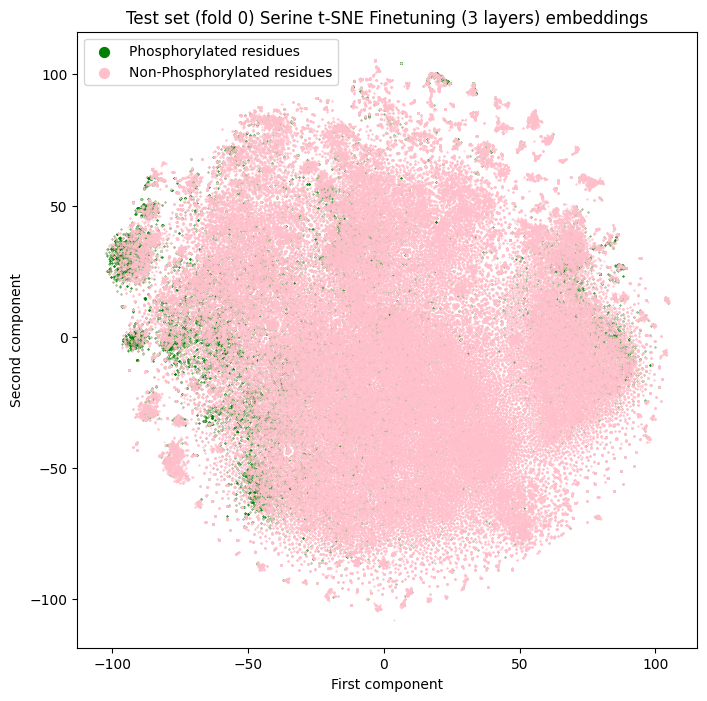

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(tp[:, 0], tp[:, 1], s=0.5, label='Phosphorylated residues', color='green', marker='.')
plt.scatter(tn[:, 0], tn[:, 1], s=0.5, label='Non-Phosphorylated residues', color='pink', marker='.')
plt.legend(markerscale=20)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Test set (fold 0) Serine t-SNE Finetuning (3 layers) embeddings')

<Axes: title={'center': 'Finetuning S (3 layers) Residue t-SNE Embeddings, Colored by Prediction'}, xlabel='First component', ylabel='Second component'>

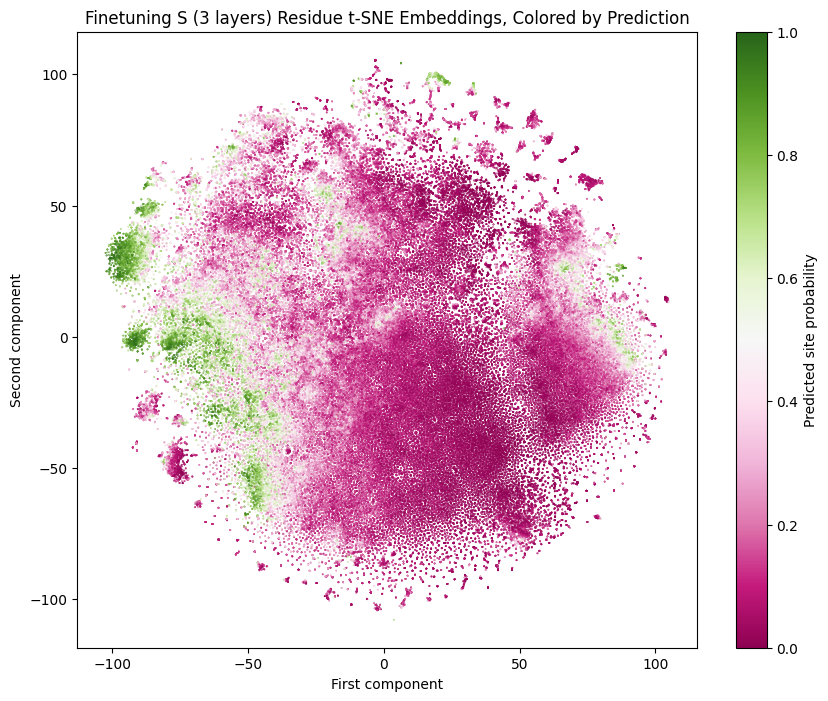

In [30]:
create_preds_plot(transformed[:, 0], transformed[:, 1], np.asarray(preds).flatten(), title='Finetuning S (3 layers) Residue t-SNE Embeddings, Colored by Prediction')